In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
#from gd1_util import R0, V0
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from gd1_util_MWhaloshape import lb_to_phi12


Populating the interactive namespace from numpy and matplotlib


### Gaia

In [2]:
gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)

In [3]:
print (gaia_dat.dtype.names)

('phi1mid', 'phi2', 'e_phi2', 'phi2width', 'e_phi2width', 'surf_bright', 'e_surf_bright', 'lindens', 'e_lindens')


In [4]:
midphi1=gaia_dat['phi1mid']
lin_den = gaia_dat['lindens']
elin_den=gaia_dat['e_lindens']
phi2=gaia_dat['phi2']
ephi2=gaia_dat['e_phi2']

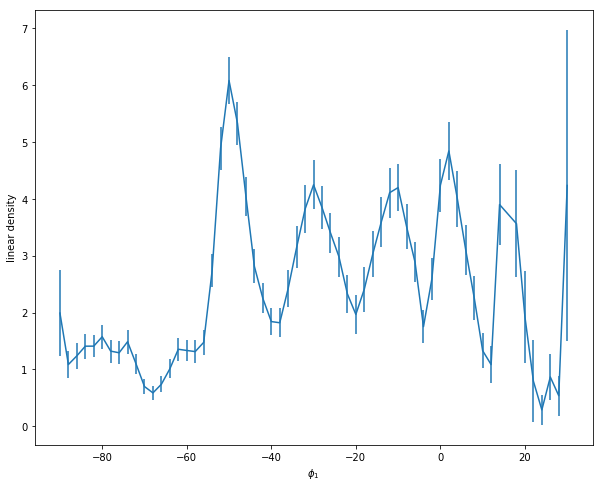

In [5]:
plt.figure(figsize=(10,8))
#plt.plot(phi1,lin_den)
plt.errorbar(midphi1,lin_den,elin_den)
#plt.plot(midphi1)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
plt.show()

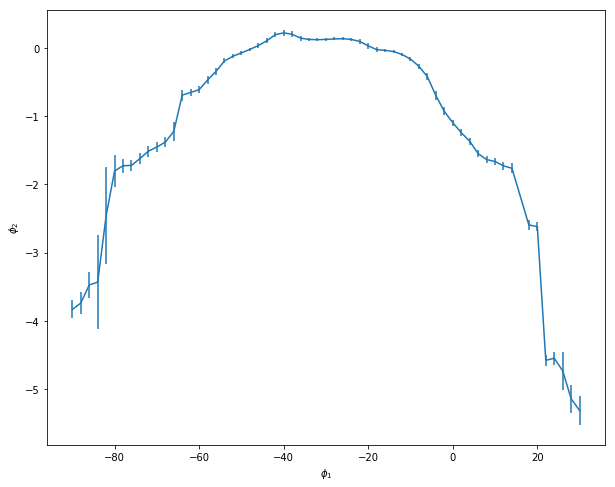

In [6]:
plt.figure(figsize=(10,8))
#plt.plot(phi1,lin_den)
plt.errorbar(midphi1,phi2,ephi2)
#plt.plot(midphi1)
plt.ylabel(r'$\phi_{2}$')
plt.xlabel(r'$\phi_{1}$')
plt.show()

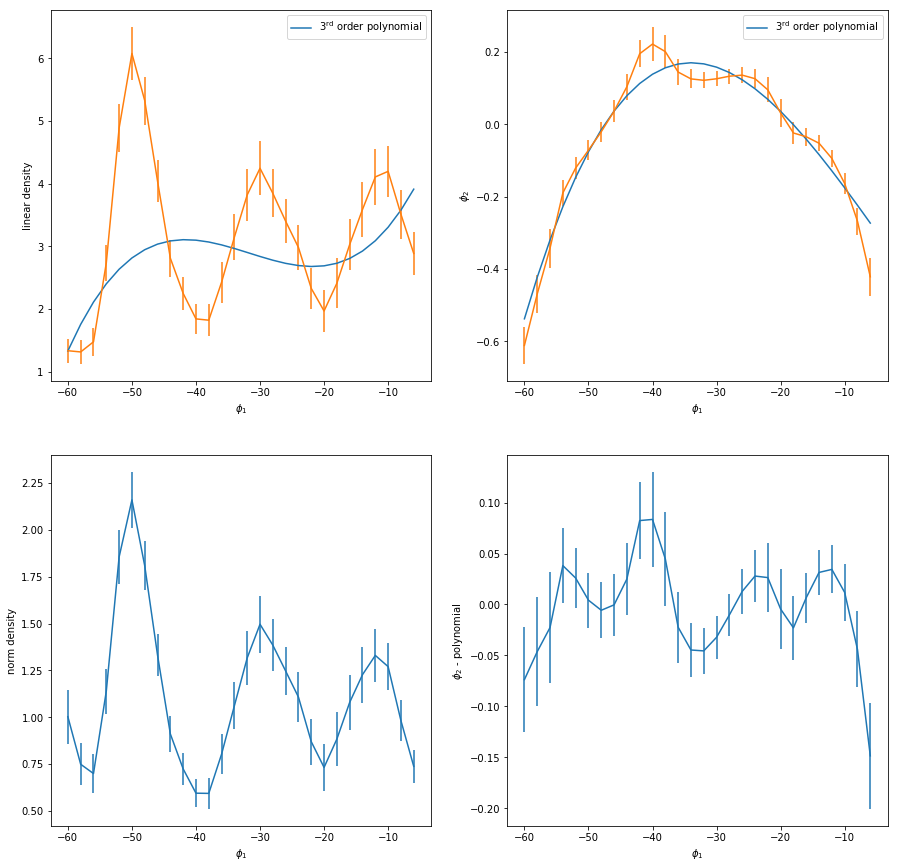

In [7]:
# Apply cuts -60. < phi1 < -5. 

phi1_cut=[]
lin_den_cut=[]
elin_den_cut=[]
phi2_cut=[]
ephi2_cut =[]

for ii in range(len(midphi1)):
    if -60. <= midphi1[ii] <= -5. :
        phi1_cut.append(midphi1[ii])
        lin_den_cut.append(lin_den[ii])
        elin_den_cut.append(elin_den[ii])
        phi2_cut.append(phi2[ii])
        ephi2_cut.append(ephi2[ii])

phi1_cut=np.array(phi1_cut)
lin_den_cut=np.array(lin_den_cut)
elin_den_cut=np.array(elin_den_cut)
phi2_cut=np.array(phi2_cut)
ephi2_cut=np.array(ephi2_cut)

        
#fit 3rd order polynomial
pp= Polynomial.fit(phi1_cut,lin_den_cut,deg=3,w=1/(elin_den_cut))  #for linear density

pp_phi2= Polynomial.fit(phi1_cut,phi2_cut,deg=3,w=1/(ephi2_cut))   # for track

#normalize density, track and errors
norm_den = lin_den_cut/pp(phi1_cut)
norm_den_err = elin_den_cut/pp(phi1_cut)
norm_phi2_cut= phi2_cut - pp_phi2(phi1_cut)


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(phi1_cut,pp(phi1_cut),label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(phi1_cut,lin_den_cut,elin_den_cut)
#plt.plot(midphi1)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.plot(phi1_cut,pp_phi2(phi1_cut),label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(phi1_cut,phi2_cut,ephi2_cut)
#plt.plot(midphi1)
plt.ylabel(r'$\phi_{2}$')
plt.xlabel(r'$\phi_{1}$')
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.errorbar(phi1_cut,norm_den,norm_den_err)
plt.ylabel(r'norm density')
plt.xlabel(r'$\phi_{1}$')

plt.subplot(2,2,4)
plt.errorbar(phi1_cut,norm_phi2_cut,ephi2_cut)
#plt.plot(midphi1)
plt.ylabel(r'$\phi_{2}$ - polynomial')
plt.xlabel(r'$\phi_{1}$')

plt.show()


In [37]:
#plot power spectrum
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    #outll= numpy.arange(-60.,-5.,0.1) ##NOTE: phi1 = -10
    outll=phi1_cut
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    #print phi1
    phi1=phi1[::-1]
    # Interpolate density
    pp= Polynomial.fit(apars,dens,deg=3)
    ipll= interpolate.InterpolatedUnivariateSpline(phi1,apars[::-1])
    #ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/pp(apars))
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


#plots power spectrum from dens already converted to observed coordinates
def pk_scatter(folder,N,scatter=False,zorder=1,ls='-',lw=2.,baryons=False,scaling='spectrum'):
    
    fnames=glob.glob(folder + '*.dat')
    filename0=fnames[0] 
    dat0=np.loadtxt(filename0)
    ll=dat0[:,0]
    tdata=dat0[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
       
    ppy= numpy.empty((N,len(px)))
          
    if baryons :
        print ('adding power due to the bar and spiral arms in quadrature')
        #power due to spiral arms and the bar
        datS= numpy.loadtxt('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs3kpc_FR1_poly3norm.dat')
        datB= numpy.loadtxt('GD1_density_botharms_1010Msun_spraydf_5Gyr_39patspeed_poly3norm.dat')
        
        p1S=datS[:,0][:-10]
        p1B=datB[:,0][:-10]
        tdataS=datS[:,1][:-10]
        tdataB=datB[:,1][:-10]
        pxS,pyS= signal.csd(tdataS,tdataS,fs=1./(p1S[1]-p1S[0]),scaling=scaling,nperseg=len(p1S))
        pxB,pyB= signal.csd(tdataB,tdataB,fs=1./(p1B[1]-p1B[0]),scaling=scaling,nperseg=len(p1B))
        pyS= pyS.real
        pyB= pyB.real
        #pxS= 1./pxS
        #pxB= 1./pxB
        py_SB2= pyS + pyB # these are already squared
                    
    else:
        py_SB2=np.zeros(len(px))
    
    ppy[0]=py + py_SB2
    
    for ii in range(1,N):
        filename=fnames[ii]
        dat=np.loadtxt(filename)
        ll=dat[:,0]
        tdata=dat[:,1]
        ppy1= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
        #print (ppy1,py_SB2)
        ppy[ii]=ppy1 + py_SB2
    
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                
    
def plot_pk_scatter(folder,N,color='k',zorder=1,ls='-',
              fill=True,fill_color='k',fill_zorder=0,label='',baryons=False):
    
    
    px, py= pk_scatter(folder=folder,N=N,baryons=baryons)
    
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        plotx, dum, low, high= pk_scatter(folder,N=N,scatter=True,baryons=baryons)
    
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    legend(loc='lower right',fontsize=12)    
    return None  


def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0][:-10]
    tdata=data[:,1][:-10]
    data_err=data[:,2][:-10]
    
    print (p1)
    
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err

#power spectrum from dens in from frequency - angle coordinates
def median_csd(filename,scatter=False,color=sns.color_palette()[0],zorder=1,ls='-',lw=2.,
            fill=False,label='',scaling='spectrum'):
    
    dens_filename=filename
    omega_filename= dens_filename.replace('dens','omega')
    dens_a= np.genfromtxt(dens_filename,delimiter=',',max_rows=5002)
    omega_a=np.genfromtxt(omega_filename,delimiter=',',max_rows=5002)
    
    #data1= numpy.loadtxt(filename,delimiter=',')
    #mOdata1= numpy.loadtxt(mOfilename,delimiter=',')
    apars= dens_a[0]
    nsim= len(dens_a)-2 # first two are apar and smooth
    if nsim < 1000:
        print ("WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename))
    
    ll,tdata1= convert_dens_to_obs(apars,dens_a[2],dens_a[1],omega_a[2])
      
    px= signal.csd(tdata1,tdata1,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    #ppysum=numpy.zeros(len(px))
    
    for ii in range(nsim):
        # convert
        try :
            ll,tdata1= convert_dens_to_obs(apars,dens_a[2+ii],dens_a[1],omega_a[2+ii])
            ppy[ii]= signal.csd(tdata1,tdata1,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[1].real
            
        except ValueError:
            print (ii)
        #print ppy[ii]
        # Same for errors
        #if not err is None:
        #    tmock1= err*numpy.random.normal(size=len(ll))
        #    ppy_err[ii]= signal.csd(tmock1,tmock1, fs=1./(ll[1]-ll[0]),scaling=scaling,
        #                                nperseg=len(ll))[1]
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    #return 1./px, ppy*(ll[-1]-ll[0])
    
    #ppysumr=ppysum.real/nsim
    #print numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
    #print ppy
    if not scatter:
        #return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
        #        numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
        
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    
    
    
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*nsim)-2)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*nsim))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*nsim)-2)]*(ll[-1]-ll[0])))
                
    
def plot_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=True,fill_color='0.',fill_zorder=0,
              err_color='k',err_zorder=0,
              label=''):
    
    
    px, py= median_csd(filename,label=label)
    
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        #fo=open('3p3keV_power_dispersion.dat','w')
        #fo.write(str('px   py   pyerr_lo   pyerr_hi') + '\n')
        plotx, dum, low, high= median_csd(filename,scatter=True,label=label)
    
        #for jj in range(len(plotx)):
        #    fo.write(str(plotx[jj]) + "   " + str(py[jj]) + "   " + str(py[jj]-low[jj]) + "   " + str(py[jj]+high[jj]) + "\n")
        #fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=err_color)
        #set_yscale('log')
        #set_xscale('log')
        #fo.close()
    return None    
        
              
def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def set_ranges_and_labels_dens_noY():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylim(0.001,20.)
    xlim(1.,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None 
    

In [9]:
with open('pkl_files/gd1pepper_Hernquist_td9.0_64sampling_MW2014.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

print (sdf_pepper._gap_leading, sdf_pepper._sigMeanSign)
            
basefilename= '/home/nil/Dropbox/streamgap-pepper/streamdata/gd1_multtime/'
dens_filename0= basefilename + '1GeVCDMx0p53/gd1bbbb_t64sampling_1GeVCDMx0p53_X5_6-9_dens_all.dat' 
dens_filename1= basefilename + '1GeV_CDM/gd1_t64sampling_1GeV_CDM_X5_5-9_9Gyr_dens_all.dat'

#bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
#figsize(7,9)
#plot_dens(dens_filename0,color='orange',zorder=1,ls='-',err_color='orange',fill=False,label=r'$53\% N_{\rm{CDM}}$')
#plot_dens(dens_filename1,color='k',zorder=1,ls='-',err_color='orange',fill=False,label=r'$N_{\rm{CDM}}$')
#set_ranges_and_labels_dens()
#plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

True -1.0


In [10]:
#Spirals
px1,py1,py_err1 = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_FR1_poly3norm.dat')
px2,py2,py_err2 = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs5kpc_FR1_poly3norm.dat')
px3,py3,py_err3 = compute_Pk('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs3kpc_FR1_poly3norm.dat')


print (px3)

[-60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36. -34.
 -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.]
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide

[-60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36. -34.
 -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.]
[-60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36. -34.
 -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.]
[        inf 56.         28.         18.66666667 14.         11.2
  9.33333333  8.          7.          6.22222222  5.6         5.09090909
  4.66666667  4.30769231  4.        ]


In [26]:
px_B,py_B,py_err_B = compute_Pk('GD1_density_botharms_1010Msun_spraydf_5Gyr_39patspeed_poly3norm.dat')

[-60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36. -34.
 -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.]
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide



/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  

[0.00354388 0.04078146 0.01569909 0.00832153 0.02850249 0.08866997
 0.08582219 0.11341851 0.16023805 0.13147794 0.15402768 0.18995708
 0.2253196  0.22318776 0.10783054]
adding power due to the bar and spiral arms in quadrature
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide

adding power due to the bar and spiral arms in quadrature
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide



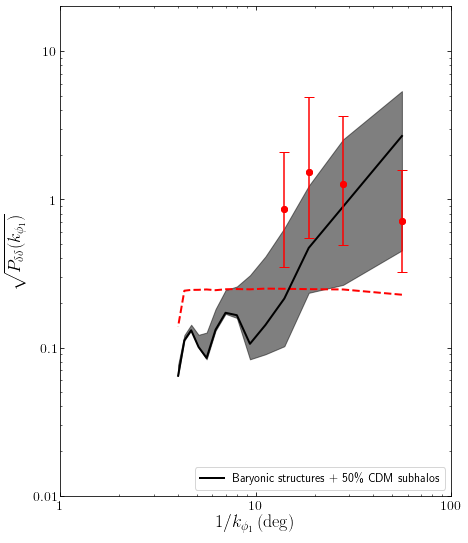

In [73]:
#Data
#compute the contribution of the noise on the power, draw Gaussian realizations of the noise and add them to the
#density and compute power, and find the 2 sigma dispersion
px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',nperseg=len(phi1_cut))
py_dat= py_dat.real
px_dat= 1./px_dat
py_dat= numpy.sqrt(py_dat*(phi1_cut[-1]-phi1_cut[0]))
           
# Perform simulations of the noise to determine the power in the noise
nerrsim= 10000
ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

ppy_noise=numpy.empty((nerrsim,len(px_dat)))

for ii in range(nerrsim):
    tmock= norm_den_err*numpy.random.normal(size=len(phi1_cut))
    tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1_cut))
    ppy_err_dat[ii]= signal.csd(tmock,tmock,
                            fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',
                            nperseg=len(phi1_cut))[1].real
    
    ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                            fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',
                            nperseg=len(phi1_cut))[1].real

py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1_cut[-1]-phi1_cut[0]))

ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1_cut[-1]-phi1_cut[0]))
print (ppy_noise_median- py_dat)

ppy_noise.sort(axis=0)

ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.159*nerrsim))]*(phi1_cut[-1]-phi1_cut[0]))
ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.84*nerrsim))]*(phi1_cut[-1]-phi1_cut[0]))
                
pcut= 0.3 # Only trust points above this, then remove noise

pyy=ppy_noise_median[py_dat>pcut]#py_dat[py_dat>pcut]**2.-py_err_dat[py_dat>pcut]**2.

low=np.sqrt(pyy**2.- ppy_noise_low[py_dat>pcut]**2.)
high=np.sqrt(pyy**2. +ppy_noise_high[py_dat>pcut]**2.)


#Plot
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

#loglog(px1,py1,color='b',zorder=1,label=r'9 Gyr N=4 Spiral, $R_{s}$ = 7 kpc')
#loglog(px2,py2,color='g',zorder=1,label=r'9 Gyr N=4 Spiral, $R_{s}$ = 5 kpc')
#loglog(px3,py3,color='cyan',zorder=1,label=r'9 Gyr N=4 Spiral, $R_{s}$ = 3 kpc')
#loglog(px_B,py_B,color='orange',zorder=1,label=r'bar')

#loglog(px1,py_err1,color='b',ls=':',zorder=1)
#loglog(px2,py_err2,color='g',ls=':',zorder=1)
#loglog(px3,py_err3,color='cyan',ls=':',zorder=1)

#plot_dens(dens_filename0,color='orange',zorder=1,ls='-',err_color='orange',fill=True,label=r'$53\% \rm{N}_{\rm{CDM}}$')
dir='dens_Omega/subhalo_GMC/0p50CDM_GMC/'
dir1= dir + 'physical_coord/'

loglog(px_dat[py_dat>pcut],numpy.sqrt(pyy),marker='o',color='r',zorder=10,ls='none')
#errorbar(px_dat[(py_dat<pcut)],numpy.amax(numpy.array([py_dat,py_err_dat]),axis=0)[py_dat<pcut],
#         yerr=numpy.array([.1+0.*px_dat[(py_dat<pcut)],.1+0.*px_dat[(py_dat<pcut)]]),
#         uplims=True,capthick=2.,ls='none',color='k',zorder=10)
loglog(px_dat,py_err_dat,lw=2.,ls='--',color='red',zorder=0)
errorbar(px_dat[py_dat>pcut],numpy.sqrt(pyy),
         yerr=[low,high]
         ,color='r',fmt='o',capsize=5.,capthick=1.,ecolor='r')


#loglog(px_dat,py_dat,color='r',ls='none',marker='o',zorder=10,label='Gaia + Pan-STARRS')
#loglog(px_dat,py_err_dat,color='r',ls='--',zorder=1)
#plot_pk_scatter('dens_Omega/combined/complete/',N=30,label=r'GMCs + Spiral + Bar',baryons=True)
plot_pk_scatter(dir1,N=500,label=r'Baryonic structures + 50\% CDM subhalos',baryons=True)
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
savefig('plots/GD-1_power_baryons_CDM_errorbars.pdf')

### Combine the powers from the baryonic components as quadrature

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide



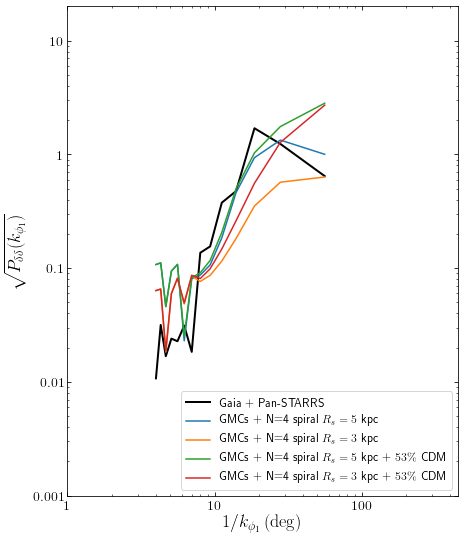

In [26]:
#Spiral Rs = 5 kpc + median GMC

px_gmc,py_gmc=pk_scatter('dens_Omega/combined/2deg_bin/',N=23,scatter=False,zorder=1,ls='-',lw=2.)

py_total = np.sqrt(py2**2. + py_gmc**2.)
py_total_1 = np.sqrt(py3**2. + py_gmc**2.)
py_total_2=np.sqrt(py2**2. + py_CDM**2.+ py_gmc**2.)
py_total_3=np.sqrt(py3**2. + py_CDM**2.+ py_gmc**2.)


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

#plot_dens(dens_filename0,color='orange',zorder=1,ls='-',err_color='orange',fill=True,label=r'$53\% \rm{N}_{\rm{CDM}}$')


loglog(px_dat,py_dat,color='k',lw=2,zorder=1,label='Gaia + Pan-STARRS')
#loglog(px_dat,py_err_dat,color='r',ls='--',zorder=1)
loglog(px_gmc,py_total,label=r'GMCs + N=4 spiral $R_{s} = 5$ kpc')
loglog(px_gmc,py_total_1,label=r'GMCs + N=4 spiral $R_{s} = 3$ kpc')
loglog(px_gmc,py_total_2,label=r'GMCs + N=4 spiral $R_{s} = 5$ kpc + $53\%$ CDM')
loglog(px_gmc,py_total_3,label=r'GMCs + N=4 spiral $R_{s} = 3$ kpc + $53\%$ CDM')
legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
savefig('plots/GD-1_quadrature_power.pdf')




/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until



Text(0,0.5,'$\\sqrt{P_{\\phi_{2}\\phi_{2}}(k_{\\phi_{1}})}$')

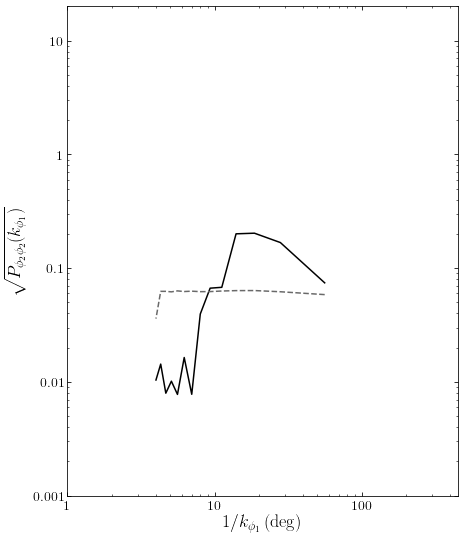

In [18]:
px,py= signal.csd(norm_phi2_cut,norm_phi2_cut,fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',nperseg=len(phi1_cut))
py= py.real
px= 1./px
py= numpy.sqrt(py*(phi1_cut[-1]-phi1_cut[0]))
    
            
# Perform simulations of the noise to determine the power in the noise
nerrsim= 10000
ppy_err= numpy.empty((nerrsim,len(px)))
for ii in range(nerrsim):
    tmock= ephi2_cut*numpy.random.normal(size=len(phi1_cut))
    ppy_err[ii]= signal.csd(tmock,tmock,
                            fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',
                            nperseg=len(phi1_cut))[1].real
py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(phi1_cut[-1]-phi1_cut[0]))


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

loglog(px,py,color='k',zorder=1)
loglog(px,py_err,color='dimgray',ls='--',zorder=1)
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\phi_{2}\phi_{2}}(k_{\phi_{1}})}$',fontsize=18)
#savefig('plots/GD-1_power_gaia.pdf')

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
#plt.plot(phi1,lin_den)
plt.plot(midphi1,phi2)

plt.ylabel(r'$\phi_{2}$')
plt.xlabel(r'$\phi_{1}$')
#plt.xlim(-20,20)
plt.ylim(-3,0.5)

plt.subplot(2,1,2)
plt.plot(midphi1,lin_den)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
#plt.xlim(-20,20)
plt.show()

### CFHT/Megacam

In [10]:
cfht_dens=np.genfromtxt('fromDenis/cfht_density.txt',names=True)
cfht_track=np.genfromtxt('fromDenis/cfht_track.txt',names=True)
print (cfht_dens.dtype.names, cfht_track.dtype.names)

('phi1', 'surf_bright') ('phi1', 'phi2', 'e_phi2', 'phi2width', 'e_phi2width')


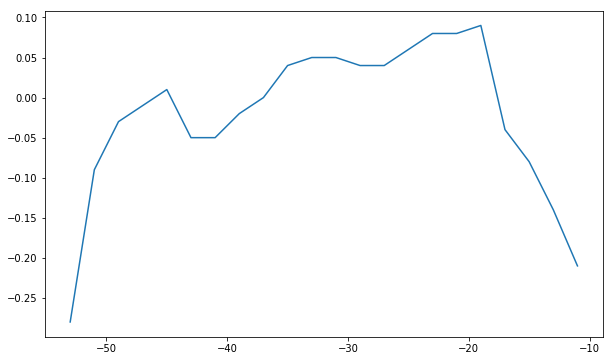

In [11]:
plt.figure(figsize=(10,6))
plt.plot(cfht_track['phi1'],cfht_track['phi2'])
#plt.xlim(-20,20)
plt.show()

### compare surface brightness 

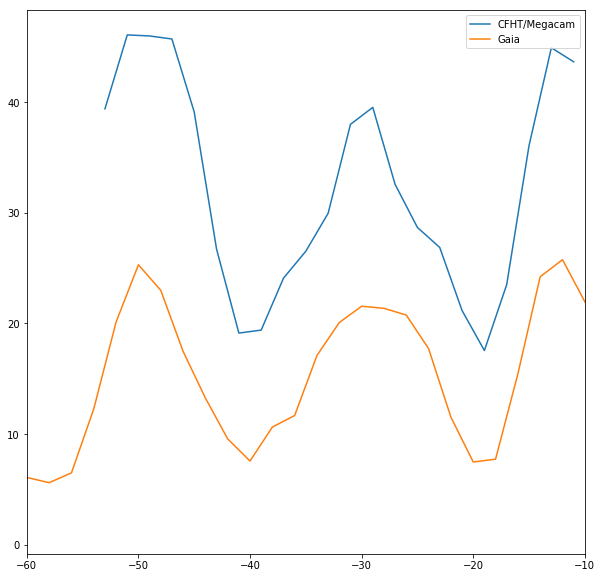

In [12]:
plt.figure(figsize=(10,10))
plt.plot(cfht_dens['phi1'],cfht_dens['surf_bright'],label='CFHT/Megacam')
plt.plot(gaia_dat['phi1mid'],gaia_dat['surf_bright'],label='Gaia')
plt.legend(loc='upper right')
plt.xlim(-60,-10)
plt.show()



### Plot N-body data

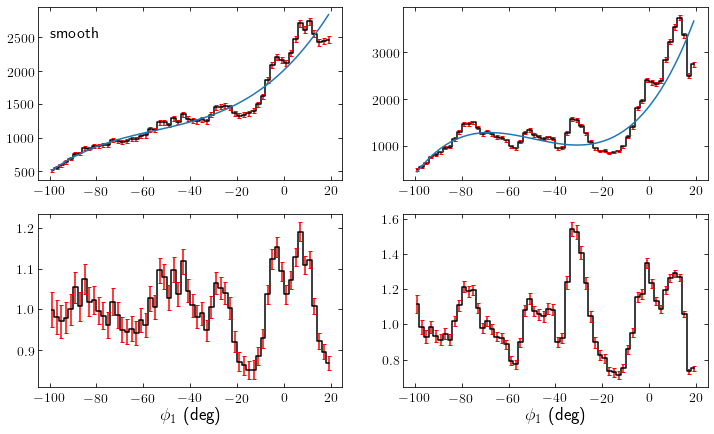

In [41]:
dat_smooth=np.loadtxt('fromDenis/gd1_density_498.txt')

dat_pert=np.loadtxt('fromDenis/gd1_density_1e5_1e8Msun_498.txt')

bin_edge=np.arange(-100.,22,2)

midbin= [0.5*(bin_edge[i] + bin_edge[i+1]) for i in range(len(bin_edge)-1)]

star_count=np.histogram(dat_smooth[:,0],bins=bin_edge,weights=dat_smooth[:,1])[0]

star_count_pert=np.histogram(dat_pert[:,0],bins=bin_edge,weights=dat_pert[:,1])[0]

#print (star_count,midbin)

shot_noise=np.sqrt(star_count)
shot_noise_pert=np.sqrt(star_count_pert)

pp= Polynomial.fit(midbin,star_count,deg=3,w=1/(shot_noise))
nden=star_count/pp(np.array(midbin))
nden_err=shot_noise/pp(np.array(midbin))

pp_pert= Polynomial.fit(midbin,star_count_pert,deg=3,w=1/(shot_noise_pert))
nden_pert=star_count_pert/pp_pert(np.array(midbin))
nden_pert_err=shot_noise_pert/pp_pert(np.array(midbin))


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12.,7.)
subplot(2,2,1)
plot(midbin,star_count,c='k',ls='steps-mid')
errorbar(midbin,star_count,shot_noise,marker='None',ls='None',capsize=2.,ecolor='r')
plot(midbin,pp(np.array(midbin)))
text(-100.,2500.,'smooth',fontsize=16)

subplot(2,2,2)
plot(midbin,star_count_pert,c='k',ls='steps-mid')
errorbar(midbin,star_count_pert,shot_noise_pert,marker='None',ls='None',capsize=2.,ecolor='r')
plot(midbin,pp_pert(np.array(midbin)))

subplot(2,2,3)
plot(midbin,nden,c='k',ls='steps-mid')
errorbar(midbin,nden,nden_err,marker='None',ls='None',capsize=2.,ecolor='r')
xlabel(r'$\phi_{1}$ (deg)')

subplot(2,2,4)
plot(midbin,nden_pert,c='k',ls='steps-mid')
errorbar(midbin,nden_pert,nden_pert_err,marker='None',ls='None',capsize=2.,ecolor='r')
xlabel(r'$\phi_{1}$ (deg)')


fo=open('Nbody_smooth_GD1.dat','w')
fo1=open('Nbody_perturbed_GD1.dat','w')

for kk in range(len(midbin)):
    fo.write(str(midbin[kk]) + "   " + str(nden[kk]) + "   " + str(nden_err[kk]) + "\n")
    fo1.write(str(midbin[kk]) + "   " + str(nden_pert[kk]) + "   " + str(nden_pert_err[kk]) + "\n")
    
    
fo.close()
fo1.close()
    


In [44]:
def compute_Pk_Nbody(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0][19:-12]
    tdata=data[:,1][19:-12]
    data_err=data[:,2][19:-12]
    
    print (p1)
    
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err

px_smooth,py_smooth,py_err_smooth=compute_Pk_Nbody('fromDenis/Nbody_smooth_GD1.dat')
px_pert,py_pert,py_err_pert=compute_Pk_Nbody('fromDenis/Nbody_perturbed_GD1.dat')

[-61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.]
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':

[-61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.]


Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

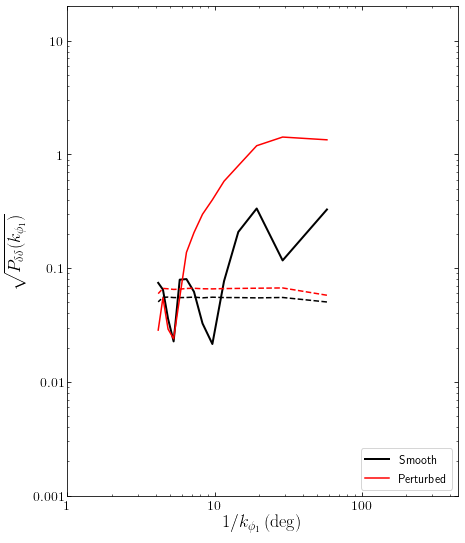

In [45]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)


loglog(px_smooth,py_smooth,color='k',lw=2,zorder=1,label='Smooth')
loglog(px_smooth,py_err_smooth,color='k',ls='--',zorder=1)

loglog(px_pert,py_pert,c='r',label=r'Perturbed')
loglog(px_pert,py_err_pert,color='r',ls='--',zorder=1)

legend(loc='lower right')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

(array([ 515.,  552.,  590.,  637.,  690.,  766.,  767.,  854.,  840.,
         872.,  877.,  890.,  893.,  968.,  958.,  941.,  954.,  979.,
         984., 1034., 1036., 1124., 1116., 1233., 1233., 1191., 1289.,
        1236., 1352., 1284., 1259., 1245., 1276., 1244., 1345., 1452.,
        1465., 1478., 1458., 1369., 1327., 1347., 1364., 1403., 1500.,
        1620., 1864., 2085., 2208., 2162., 2120., 2267., 2473., 2704.,
        2609., 2739., 2553., 2424., 2444., 2462.]),
 array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
         -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
         -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
         -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
         -28.,  -26.,  -24.,  -22.,  -20.,  -18.,  -16.,  -14.,  -12.,
         -10.,   -8.,   -6.,   -4.,   -2.,    0.,    2.,    4.,    6.,
           8.,   10.,   12.,   14.,   16.,   18.,   20.]),
 <a list of 1 Patch objects>)

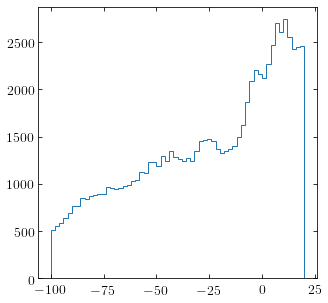

In [33]:
px_smooth,py_smooth= signal.csd(nden_cut,nden_cut,fs=1./(midbin_cut[1]-midbin_cut[0]),scaling='spectrum',nperseg=len(midbin_cut))
py_smooth= py_smooth.real
px_smooth= 1./px_smooth
py_smooth= numpy.sqrt(py_smooth*(midbin_cut[-1]-midbin_cut[0]))
           
# Perform simulations of the noise to determine the power in the noise
nerrsim= 10000
ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))
for ii in range(nerrsim):
    tmock= norm_den_err*numpy.random.normal(size=len(phi1_cut))
    ppy_err_dat[ii]= signal.csd(tmock,tmock,
                            fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',
                            nperseg=len(phi1_cut))[1].real
py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1_cut[-1]-phi1_cut[0]))

In [ ]:
def setup_pal5model(leading=False,pot=MWPotential2014,orb=[229.018,-0.124,23.2,-2.296,-2.257,-58.7],
                    timpact=None,b=0.8,
                    hernquist=True,
                    age=5.,
                    singleImpact=False,
                    length_factor=1.,
                    **kwargs):
    obs= Orbit(orb,radec=True,ro=R0,vo=V0,
               solarmotion=[-11.1,24.,7.25])


orb=[176.491594, 53.728492,9.292278,-6.908567, -7.157146,-190.409253]

v_sun = (11.1       ,  ,    7.3) km/s


obs=Orbit(orb,radec=True,solarmotion=[-11.1,242.46254739-220.,7.25],ro=8.3,vo=220.)
    
sigv= 0.365/2.*(9./age) #km/s, /2 bc tdis x2, adjust for diff. age